Notebook para avaliar modelo treinado com UA através da classificação do dataset com imagens sintéticas.

Modelo Classificador

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Classificação com imagens reais

In [56]:
from data import create_dataset
from options.train_options import TrainOptions
import sys

Centralizado

Loaded 59997 examples
images dtype: uint8 shape: (59997, 28, 28)
labels dtype: int64 shape: (59997,)


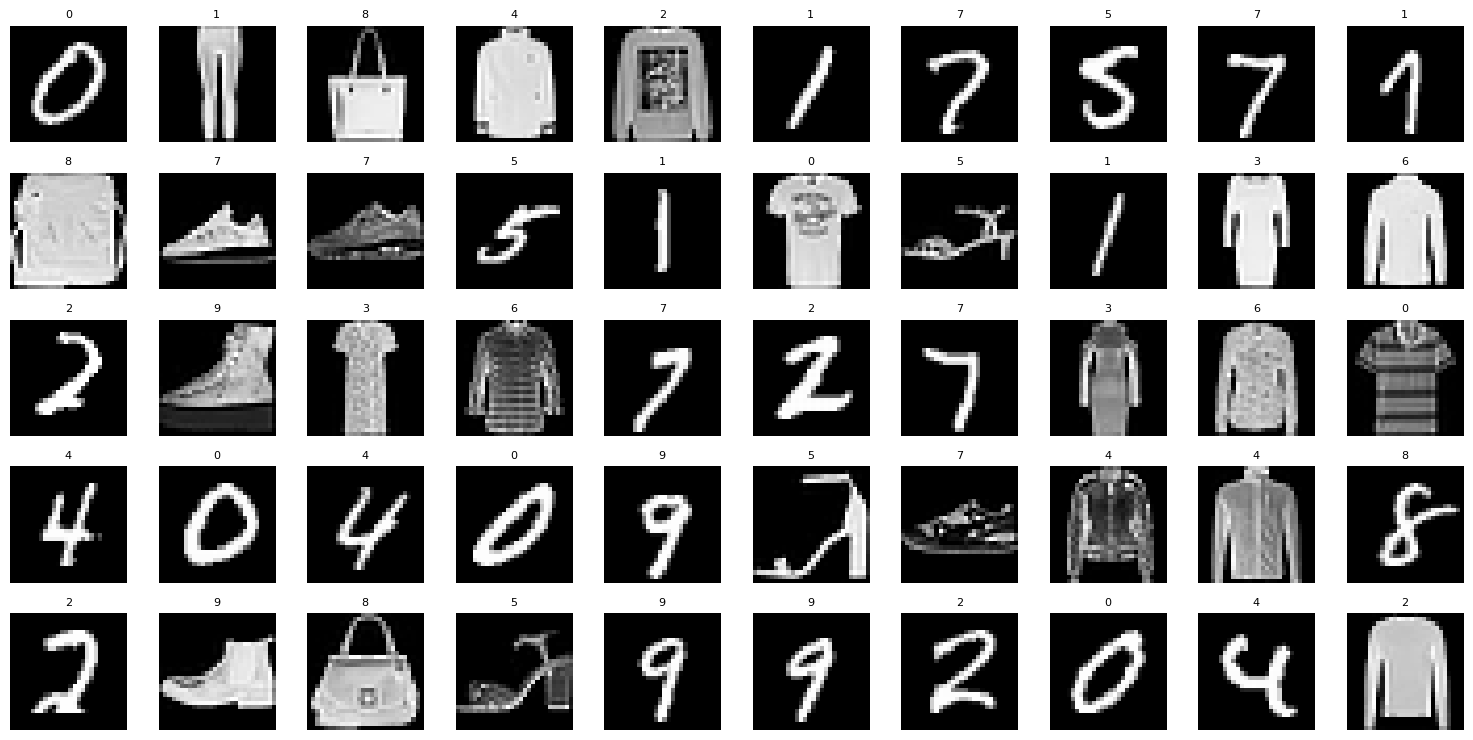

In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File('data/MNIST_fashionMNIST_imbalanced/train_MNIST_fashionMNIST.h5', 'r') as f:
    img_group = f['images']
    lbl_group = f['labels']
    keys = list(img_group.keys())
    n = len(keys)

    # Preallocate
    sample_img = img_group[keys[0]][()]
    H, W = sample_img.shape
    images = np.zeros((n, H, W), dtype=sample_img.dtype)
    labels = np.zeros((n,), dtype=int)

    for i, k in enumerate(keys):
        images[i] = img_group[k][()]
        labels[i] = lbl_group[k][()]

    # Shuffle
    perm = np.random.permutation(n)
    images = images[perm]
    labels = labels[perm]

    print("Loaded", n, "examples")
    print("images dtype:", images.dtype, "shape:", images.shape)
    print("labels dtype:", labels.dtype, "shape:", labels.shape)

    # Plot first 50 in a 5×10 grid
    num_to_show = 50
    rows, cols = 5, 10
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for idx in range(num_to_show):
        r, c = divmod(idx, cols)
        axes[r, c].imshow(images[idx], cmap='gray')
        axes[r, c].set_title(f"{labels[idx]}", fontsize=8)
        axes[r, c].axis('off')
    for idx in range(num_to_show, rows*cols):
        r, c = divmod(idx, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()


In [24]:
args = [
    '--dataroot', './data/MNIST_fashionMNIST_imbalanced',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist',
    '--pool_size', '0',
    '--gpu_ids', '-1',
    '--niter', '200',
    '--niter_decay', '200',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
]

In [52]:
sys.argv = ['train.py'] + args
opt = TrainOptions().parse()
dataset = create_dataset(opt)

----------------- Options ---------------
               batch_size: 256                           	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 32                            
                 dataroot: ./data                        	[default: None]
             dataset_mode: mnist_fashionmnist            	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 8                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 64                            
                    epoch: latest     

dataset [MNISTFashionMNISTDataset] was created


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [43]:
for epoch in range(100):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["B"].to(device), data["A"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(dataset):.3f}')

print('Finished Training')

[1,   235] loss: 0.002
[2,   235] loss: 0.001
[3,   235] loss: 0.001
[4,   235] loss: 0.001
[5,   235] loss: 0.001
[6,   235] loss: 0.001
[7,   235] loss: 0.001
[8,   235] loss: 0.001
[9,   235] loss: 0.001
[10,   235] loss: 0.001
[11,   235] loss: 0.001
[12,   235] loss: 0.001
[13,   235] loss: 0.001
[14,   235] loss: 0.001
[15,   235] loss: 0.001
[16,   235] loss: 0.001
[17,   235] loss: 0.001
[18,   235] loss: 0.001
[19,   235] loss: 0.001
[20,   235] loss: 0.001
[21,   235] loss: 0.001
[22,   235] loss: 0.001
[23,   235] loss: 0.001
[24,   235] loss: 0.001
[25,   235] loss: 0.001
[26,   235] loss: 0.000
[27,   235] loss: 0.000
[28,   235] loss: 0.001
[29,   235] loss: 0.001
[30,   235] loss: 0.000
[31,   235] loss: 0.000
[32,   235] loss: 0.001
[33,   235] loss: 0.000
[34,   235] loss: 0.000
[35,   235] loss: 0.000
[36,   235] loss: 0.000
[37,   235] loss: 0.000
[38,   235] loss: 0.000
[39,   235] loss: 0.000
[40,   235] loss: 0.000
[41,   235] loss: 0.000
[42,   235] loss: 0.000
[

In [44]:
torch.save(net.state_dict(), 'net_100e_mnistfmnistimb.pth')

In [50]:
args = [
    '--dataroot', './data',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist',
    '--gpu_ids', '-1',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
    '--serial_batches'
]

In [58]:
from options.test_options import TestOptions

In [62]:
import importlib
import data.mnist_fashionmnist_dataset
import data

importlib.reload(data.mnist_fashionmnist_dataset)
importlib.reload(data)

<module 'data' from '/Users/Mara/Documents/Mestrado/Pesquisa/UA/UAGAN/data/__init__.py'>

In [63]:
sys.argv = ['test.py'] + args
opt = TestOptions().parse()
opt.isTrain = False
testset = create_dataset(opt)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 256                           	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 32                            
                 dataroot: ./data                        	[default: None]
             dataset_mode: mnist_fashionmnist            	[default: unaligned]
                direction: AtoB                          
          display_winsize: 64                            
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
         

In [65]:
correct, loss = 0, 0.0
net.eval()
with torch.no_grad():
    for batch in testset:
        images = batch["B"].to(device)
        labels = batch["A"].to(device)
        outputs = net(images)
        loss += criterion(outputs, labels).item()
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
accuracy = correct / len(testset.dataset)
loss = loss / len(testset)

In [68]:
accuracy

0.9199

Federado NIID (fmnist iid e mnist uma classe por cliente)

In [4]:
args = [
    '--dataroot', './data/MNIST_fashionMNIST_imbalanced',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist_split',
    '--pool_size', '0',
    '--gpu_ids', '-1',
    '--niter', '200',
    '--niter_decay', '200',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
]

In [7]:
sys.argv = ['train.py'] + args

In [8]:
opt = TrainOptions().parse()

----------------- Options ---------------
               batch_size: 256                           	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 32                            
                 dataroot: ./data/MNIST_fashionMNIST_imbalanced	[default: None]
             dataset_mode: mnist_fashionmnist_split      	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 8                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 64                            
                    epoch: lates

In [9]:
dataset = create_dataset(opt)

Load: train_MNIST_unique_fashionMNIST_uniform_0.h5
Load: train_MNIST_unique_fashionMNIST_uniform_1.h5
Load: train_MNIST_unique_fashionMNIST_uniform_2.h5
Load: train_MNIST_unique_fashionMNIST_uniform_3.h5
Load: train_MNIST_unique_fashionMNIST_uniform_4.h5
Load: train_MNIST_unique_fashionMNIST_uniform_5.h5
Load: train_MNIST_unique_fashionMNIST_uniform_6.h5
Load: train_MNIST_unique_fashionMNIST_uniform_7.h5
Load: train_MNIST_unique_fashionMNIST_uniform_8.h5
Load: train_MNIST_unique_fashionMNIST_uniform_9.h5
dataset [MNISTFashionMNISTSplitDataset] was created
